<a href="https://colab.research.google.com/gist/yandod/7c805458f563bac835144bf1e7896a35/dreambooth_02feb-ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #**install dreambooth**
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers


In [ ]:
#@title #**login to HuggingFace**

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

In [ ]:
#@title #**setting folder**

# define function
import os
import shutil
def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob
def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()

# setting
MODEL_NAME = "CompVis/stable-diffusion-v1-4" 

INSTANCE = "yando"#@param {type:"string"}
INSTANCE_DIR = "/content/data/"+INSTANCE 
reset_folder(INSTANCE_DIR)

CLASS = "portrait" #@param {type:"string"}
CLASS_DIR = "/content/data/"+CLASS
reset_folder(CLASS_DIR)

OUTPUT_DIR = "/content/stable_diffusion_weights/" + INSTANCE
reset_folder(OUTPUT_DIR)


concepts_list = [
    {
        "instance_prompt":      INSTANCE,
        "class_prompt":         CLASS,
        "instance_data_dir":     INSTANCE_DIR,
        "class_data_dir":        CLASS_DIR
    },
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
#@title #**upload pics**
import os
from google.colab import files
import shutil
import gdown

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

%matplotlib inline
display_pic(INSTANCE_DIR)

In [ ]:
#@title #**train** (takes 15minutes)

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt=$CLASS \
  --concepts_list="concepts_list.json"


In [ ]:
#@title #**make pipe for generating images**

# Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" 
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR.rstrip(os.sep)+"/*"))[-1]

# Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

g_cuda = None

# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

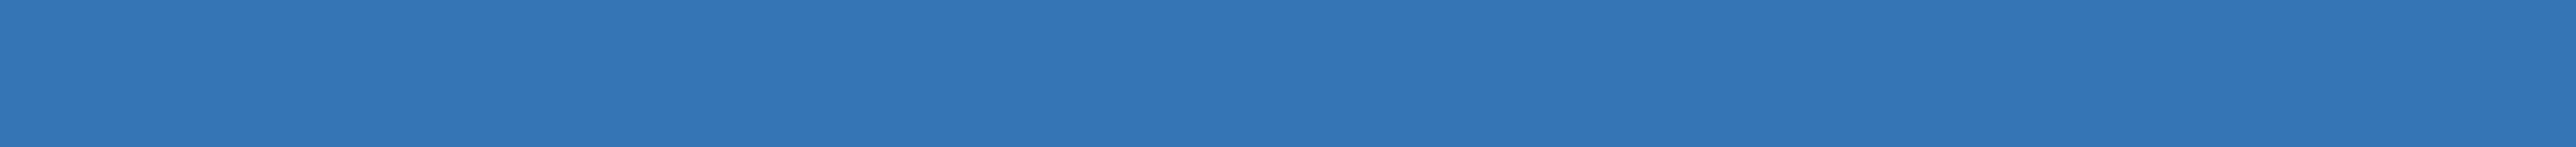

In [ ]:
#@title #**manual generat images**

reset_folder('images')

# prompt
prompt = "yando in Edward Hopper paint" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}

# other setting
num_samples = 10 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512 

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    display(img)

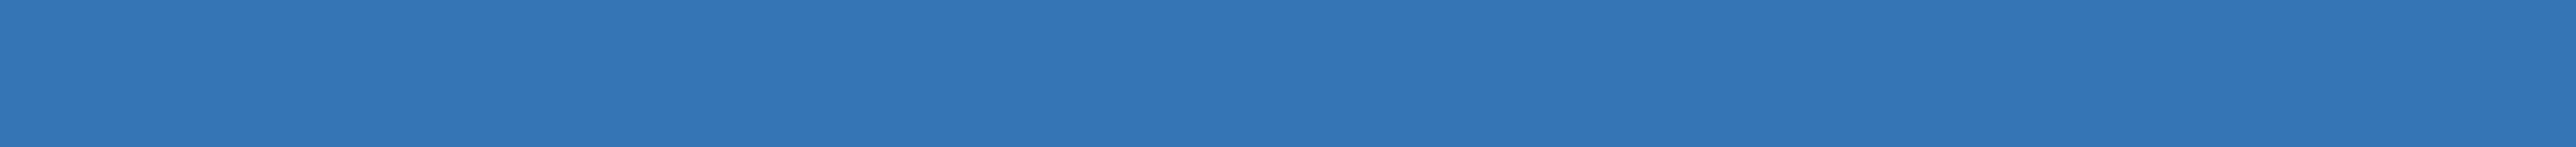